This notebook contains the detailed experiments and numerical study results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from tqdm.auto import tqdm
from typing import List, Tuple, Union
import time
import warnings

# import the utility functions
from detections import AligatorCPPDetector, WinMaxDetector, FixedWindowDetector, WaterSeekerDetector, SeedBSNOTDetectorCPP, WISERDetector
from watermarking_func import null_distn_gumbel, null_distn_inverse, null_distn_redgreen, null_distn_pf
from llm_utilities import (
    read_json, get_iou, get_hit_counts, 
    get_rand_index, get_modified_rand_index
)

## Define Utility Functions

In [2]:
# define a utility function which provides summarized results

def get_summarized_results(data, get_interval_func, add_plot = False, verbose = True):
    metrics_list = []
    interval_endpoints = []
    true_intervals =  [
        (start, end) for (start, end, interval_type) in data['configuration']['intervals'] if interval_type != 'unwatermarked'
    ]

    n = 0
    iterator = list(enumerate(data["data"]))
    if verbose:
        iterator = tqdm(iterator)
    for sample_index, sample_data in iterator:
        pivots = sample_data["pivots"]
        n = max(n, len(pivots))
        pivots = np.array(pivots)
        pivots[np.isinf(pivots)] = pivots[~np.isinf(pivots)].max() # replace by maximum for infinite values
        est_intervals, time_taken = get_interval_func(pivots)
        
        # add detected endpoints to array
        for left_end, right_end in est_intervals:
            interval_endpoints.append(left_end)
            interval_endpoints.append(right_end)

        # calculate metrics
        hit_count = get_hit_counts(true_intervals, est_intervals)
        ri, mod_ri = get_modified_rand_index(true_intervals, est_intervals, n)
        metric_row = {
            "sample_index": sample_index,
            "detected_intervals_count": len(est_intervals),
            "iou": get_iou(est_intervals, true_intervals),
            "recall": hit_count / max(len(true_intervals), 1),  # Recall
            "precision": hit_count / max(len(est_intervals), 1),  # Precision
            "rand_index": ri,
            "modified_rand_index": mod_ri,
            "time": time_taken
        }
        metrics_list.append(metric_row)

    metric_df = pd.DataFrame(metrics_list)
    # metric_df['f1'] = 2 * metric_df['precision'] * metric_df['recall'] / (metric_df['precision'] + metric_df['recall'])
    f1 = 2 * metric_df['precision'].mean() * metric_df['recall'].mean() / (metric_df['precision'].mean() + metric_df['recall'].mean())

    return {
        "model_name": data['configuration']['model_name'],
        "iou": metric_df['iou'].mean(),
        "precision": metric_df['precision'].mean(),
        "recall": metric_df['recall'].mean(),
        "f1": f1,
        "rand_index": metric_df['rand_index'].mean(),
        "modified_rand_index": metric_df['modified_rand_index'].mean()
    }

## Experiment: Calculate Benchmark Metrics

In [4]:
null_dist_list = {
    "gumbel": null_distn_gumbel,
    "inverse": null_distn_inverse,
    "redgreen": null_distn_redgreen,
    "pf": null_distn_pf
}
root_output_path = "../data/output"
model_list = [
    "data_facebook-opt-125m_n500",
    "data_google-gemma-3-270m_n500",
    "data_facebook-opt-1-3b_n500",
    "data_princeton-nlp-Sheared-LLaMA-1-3B_n500",
    "data_mistralai-Mistral-7B-v0-1_n500",
    "data_meta-llama-Meta-Llama-3-8B_n500"
]
watermark_method = "gumbel"  # MODIFY here to change watermarking schemes
null_distn = null_dist_list[watermark_method]

In [ ]:
outputs = []
for fmodel in tqdm(model_list):
    fname = f"{fmodel}_{watermark_method}.json"
    data = read_json(os.path.join(root_output_path, fname))
    vocab_size = data['configuration']['vocab_size']
    model_name = data['configuration']['model_name']
    # print(f"\n\nLoaded file {fname} with model {model_name} and vocab size {vocab_size}\n")

    # Run WISER
    def get_epidemic_intervals(x):
        d = WISERDetector(vocab_size)
        return d.detect(x, null_distn=null_distn, block_size=65, c = 1) 
    
    res = get_summarized_results(data, get_epidemic_intervals, verbose=False)
    res['method'] = "Epidemic"
    res['model_name'] = model_name
    res['vocab_size'] = vocab_size
    outputs.append(res)


    # Run aligator
    def get_aligator_intervals(x):
        d = AligatorCPPDetector(vocab_size)
        return d.detect(np.array(x), null_distn)
        
    res = get_summarized_results(data, get_aligator_intervals, verbose=False)
    res['method'] = "Aligator"
    res['model_name'] = model_name
    res['vocab_size'] = vocab_size
    outputs.append(res)

    # Run seedbs
    def get_seedbs_intervals(x):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            d = SeedBSNOTDetectorCPP(vocab_size, n_jobs=1)
            return d.detect(x, null_distn)
    res = get_summarized_results(data, get_seedbs_intervals, verbose=False)
    res['method'] = "SeedBS_NOT"
    res['model_name'] = model_name
    res['vocab_size'] = vocab_size
    outputs.append(res)

    # # Run fixed width
    # def get_fixedwidth_intervals(x):
    #     d = FixedWindowDetector(vocab_size)
    #     return d.detect(x, null_distn)
    # res = get_summarized_results(data, get_fixedwidth_intervals, verbose=False)
    # res['method'] = "FW"
    # res['model_name'] = model_name
    # res['vocab_size'] = vocab_size
    # outputs.append(res)
    
    # Run waterseeker
    def get_seek_intervals(x):
        d = WaterSeekerDetector(vocab_size)
        return d.detect(x, null_distn)
    res = get_summarized_results(data, get_seek_intervals, verbose=False)
    res['method'] = "Waterseeker"
    res['model_name'] = model_name
    res['vocab_size'] = vocab_size
    outputs.append(res)


output_df = pd.DataFrame(outputs)
output_df = output_df.round(3)  # round to 3 digits for latex output
output_df.head()

  0%|          | 0/6 [00:00<?, ?it/s]

,model_name,iou,precision,recall,f1,rand_index,modified_rand_index,method,vocab_size
0,facebook/opt-125m,0.934,1.000,0.995,0.997,0.980,0.979,Epidemic,50272
1,facebook/opt-125m,0.734,0.382,0.988,0.551,0.939,0.931,Aligator,50272
2,facebook/opt-125m,0.504,0.745,0.638,0.687,0.852,0.819,SeedBS_NOT,50272
3,facebook/opt-125m,0.672,1.000,0.802,0.890,0.864,0.850,Waterseeker,50272
4,google/gemma-3-270m,0.903,0.965,0.960,0.962,0.953,0.950,Epidemic,262144
5,google/gemma-3-270m,0.506,0.234,0.912,0.373,0.881,0.861,Aligator,262144
6,google/gemma-3-270m,0.347,0.615,0.468,0.531,0.741,0.698,SeedBS_NOT,262144
7,google/gemma-3-270m,0.645,0.970,0.778,0.863,0.852,0.836,Waterseeker,262144
8,facebook/opt-1.3b,0.921,1.000,0.995,0.997,0.976,0.974,Epidemic,50272
9,facebook/opt-1.3b,0.497,0.235,0.920,0.375,0.892,0.871,Aligator,50272


In [6]:
output_df = output_df[['model_name', 'vocab_size', 'method', 'iou', 'precision', 'recall', 'f1', 'rand_index', 'modified_rand_index']].round(3)
print(output_df.to_latex(index=False, float_format="%.3f"))  # print latex table format for easy-copying

\begin{tabular}{lrlrrrrrr}
\toprule
model_name & vocab_size & method & iou & precision & recall & f1 & rand_index & modified_rand_index \\
\midrule
facebook/opt-125m & 50272 & Epidemic & 0.934 & 1.000 & 0.995 & 0.997 & 0.980 & 0.979 \\
facebook/opt-125m & 50272 & Aligator & 0.734 & 0.382 & 0.988 & 0.551 & 0.939 & 0.931 \\
facebook/opt-125m & 50272 & SeedBS_NOT & 0.504 & 0.745 & 0.638 & 0.687 & 0.852 & 0.819 \\
facebook/opt-125m & 50272 & Waterseeker & 0.672 & 1.000 & 0.802 & 0.890 & 0.864 & 0.850 \\
google/gemma-3-270m & 262144 & Epidemic & 0.903 & 0.965 & 0.960 & 0.962 & 0.953 & 0.950 \\
google/gemma-3-270m & 262144 & Aligator & 0.506 & 0.234 & 0.912 & 0.373 & 0.881 & 0.861 \\
google/gemma-3-270m & 262144 & SeedBS_NOT & 0.347 & 0.615 & 0.468 & 0.531 & 0.741 & 0.698 \\
google/gemma-3-270m & 262144 & Waterseeker & 0.645 & 0.970 & 0.778 & 0.863 & 0.852 & 0.836 \\
facebook/opt-1.3b & 50272 & Epidemic & 0.921 & 1.000 & 0.995 & 0.997 & 0.976 & 0.974 \\
facebook/opt-1.3b & 50272 & Aligator &

## Experiment: Speed Comparison

In [7]:
from itertools import product
from p_tqdm import p_map

In [8]:
B = 50  # number of replications
vocab_size = 10000
nlist = [100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 5000, 7500, 10000]

def run_calculation(input):
    rows = []
    n, b = input
    pivots = np.random.standard_exponential(size = n)  # (n, )  # generate sample gumbel pivots
    random_index = int(np.random.rand() * n/2)
    pivots[random_index:(random_index + int(n/6))] += 5  # create some simulated wm segments

    # run aligator
    d = AligatorCPPDetector(vocab_size)
    _, t = d.detect(pivots, null_distn_gumbel)
    rows.append({ "index": b, "n": n, "method": "Aligator", "time": t })

    # # run fw
    # d = FixedWindowDetector(vocab_size)
    # _, t = d.detect(pivots, null_distn_gumbel)
    # rows.append({ "index": b, "n": n, "method": "FW", "time": t })

    # # run seedbs
    d = SeedBSNOTDetectorCPP(vocab_size)
    _, t = d.detect(pivots, null_distn_gumbel)
    rows.append({ "index": b, "n": n, "method": "SeedBS-NOT", "time": t })

    # run waterseeker
    d = WaterSeekerDetector(vocab_size)
    _, t = d.detect(pivots, null_distn_gumbel)
    rows.append({ "index": b, "n": n, "method": "Waterseeker", "time": t })

    # run epidemic
    d = WISERDetector(vocab_size)
    _, t = d.detect(pivots, null_distn_gumbel)
    rows.append({ "index": b, "n": n, "method": "WISER", "time": t })

    return rows

parallel_rows = p_map(
    run_calculation,
    list(product(nlist, range(B))),
    num_cpus = 8
)

output_rows = [row for rows in parallel_rows for row in rows]
timedf = pd.DataFrame(output_rows)
timedf.head()

  0%|          | 0/600 [00:00<?, ?it/s]

,index,n,method,time
0,0,100,Aligator,0.003711
1,0,100,SeedBS-NOT,0.002923
2,0,100,Waterseeker,0.000134
3,0,100,WISER,0.000134
4,1,100,Aligator,0.003401


(2400, 4)


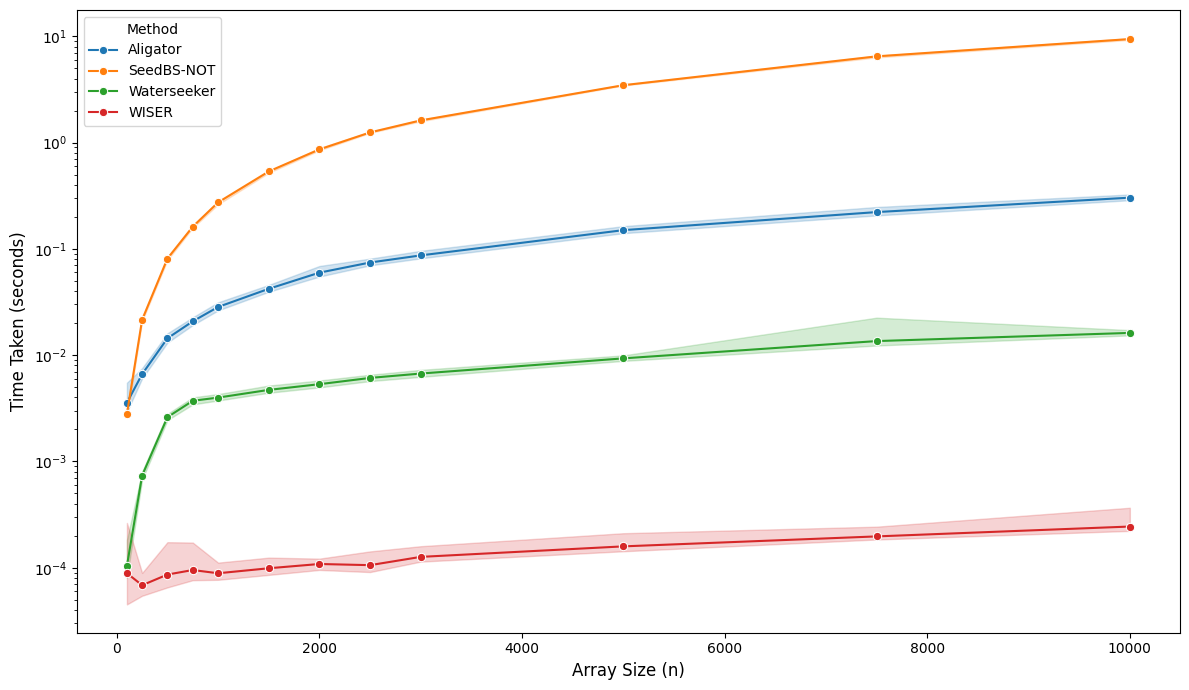

In [9]:
print(timedf.shape)

plt.figure(figsize=(12, 7))
plot = sns.lineplot(
    data=timedf,
    x='n',
    y='time',
    hue='method',
    marker='o',
    errorbar=('pi', 95)
)

# plot.set_xscale('log')  # plot in log scale
plot.set_yscale('log')

# plot.set_title('Method Performance vs. Array Size (n)', fontsize=16, weight='bold')
plot.set_xlabel('Array Size (n)', fontsize=12)
plot.set_ylabel('Time Taken (seconds)', fontsize=12)
plt.legend(title='Method', fontsize=10)
plt.tight_layout() # Adjust layout to make sure everything fits

## Experiment: Ablation Study

In [10]:
fname = "data_google-gemma-3-270m_n501_gumbel.json"
data = read_json(os.path.join(root_output_path, fname))
true_intervals =  [(start, end) for (start, end, interval_type) in data['configuration']['intervals'] if interval_type != 'unwatermarked']
vocab_size = data['configuration']['vocab_size']

In [14]:
block_sizes = [5, 10, 25, 50, 75, 125, 175, 250]

rows = []
for i, block_size in tqdm(list(product(range(len(data['data'])), block_sizes))):
    pivots = np.array(data['data'][i]['pivots'])
    pivots[np.isinf(pivots)] = pivots[~np.isinf(pivots)].max() # replace by maximum for infinite values

    # perform detection
    d = WISERDetector(vocab_size, rho = 0.25)
    est_intervals, time_taken = d.detect(pivots, null_distn_gumbel, block_size=block_size)
    ri, mri = get_modified_rand_index(est_intervals, true_intervals, pivots.shape[0])

    rows.append({
        "sample_index": i,
        "block_size": block_size,
        "IOU": get_iou(est_intervals, true_intervals),
        "RI": ri,
        "MRI": mri
    })

# convert to dataframe
blocks_df = pd.DataFrame(rows)
blocks_df.shape

  0%|          | 0/1600 [00:00<?, ?it/s]

(1600, 5)

/var/folders/v9/p596rfjn6f5cxry5bh_b_0cw0000gn/T/ipykernel_2019/1281492301.py:13: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  ax = sns.boxplot(data=long_df, x="block_size", y="Score", hue="Metric", palette=palette, width=0.6, fliersize=2)


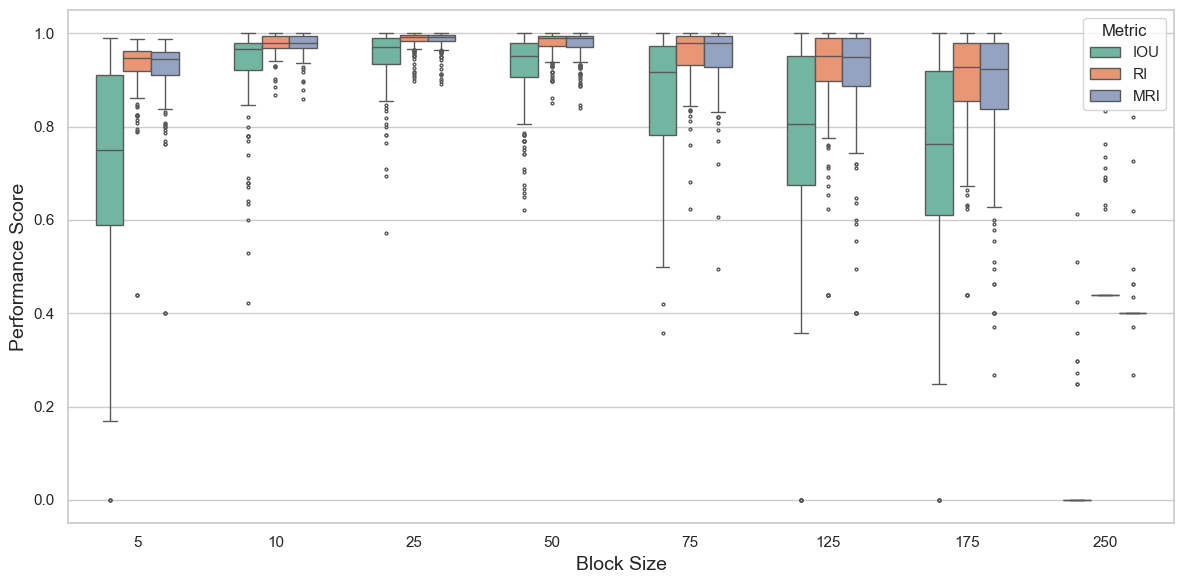

In [15]:
long_df = blocks_df.melt(
    id_vars=["sample_index", "block_size"],
    value_vars=["IOU", "RI", "MRI"],
    var_name="Metric",
    value_name="Score"
)

# set style
sns.set_theme(style="whitegrid")
palette = sns.color_palette("Set2")  # custom color palette (colorblind friendly)

plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=long_df, x="block_size", y="Score", hue="Metric", palette=palette, width=0.6, fliersize=2)

# ax.set_title("Ablation Study: Effect of Block Size on Detection Performance", fontsize=18, pad=20)
ax.set_xlabel("Block Size", fontsize=14)
ax.set_ylabel("Performance Score", fontsize=14)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # rotate x labels if needed
# handles, labels = ax.get_legend_handles_labels() # improve legend
# ax.legend(handles[:2], labels[:2], title="Metric", loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False)

plt.tight_layout()
plt.show()

In [28]:
rho_vals = np.arange(0.1, 1, step=0.1)

rows = []
for i, rho in tqdm(list(product(range(len(data['data'])), rho_vals))):
    pivots = np.array(data['data'][i]['pivots'])
    pivots[np.isinf(pivots)] = pivots[~np.isinf(pivots)].max() # replace by maximum for infinite values

    # perform detection
    d = WISERDetector(vocab_size, rho = round(float(rho), 3))
    est_intervals, time_taken = d.detect(pivots, null_distn_gumbel, block_size=25)  # keep block_size fixed
    ri, mri = get_modified_rand_index(est_intervals, true_intervals, pivots.shape[0])

    rows.append({
        "sample_index": i,
        "rho": rho,
        "IOU": get_iou(est_intervals, true_intervals),
        "RI": ri,
        "MRI": mri 
    })

# convert to dataframe
rho_df = pd.DataFrame(rows)
print(rho_df.shape)

  0%|          | 0/1800 [00:00<?, ?it/s]

(1800, 5)


/var/folders/v9/p596rfjn6f5cxry5bh_b_0cw0000gn/T/ipykernel_2019/879123478.py:14: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  ax = sns.boxplot(data=long_df, x="rho_label", y="Score", hue="Metric", palette=palette, width=0.6, fliersize=2)


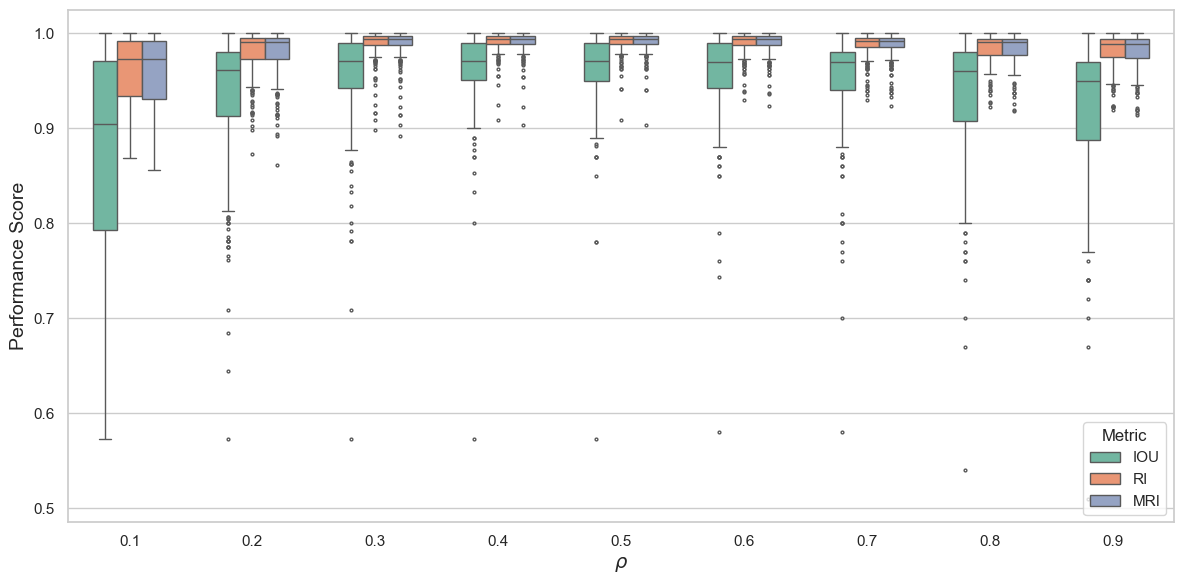

In [29]:
rho_df["rho_label"] = rho_df["rho"].map(lambda x: f"{x:.1f}")
long_df = rho_df.melt(
    id_vars=["sample_index", "rho_label"],
    value_vars=["IOU", "RI", "MRI"],
    var_name="Metric",
    value_name="Score"
)

# set style
sns.set_theme(style="whitegrid")
palette = sns.color_palette("Set2")  # custom color palette (colorblind friendly)

plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=long_df, x="rho_label", y="Score", hue="Metric", palette=palette, width=0.6, fliersize=2)

# ax.set_title("Ablation Study: Effect of Block Size on Detection Performance", fontsize=18, pad=20)
ax.set_xlabel(r"$\rho$", fontsize=14)
ax.set_ylabel("Performance Score", fontsize=14)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # rotate x labels if needed
# handles, labels = ax.get_legend_handles_labels() # improve legend
# ax.legend(handles[:2], labels[:2], title="Metric", loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False)

plt.tight_layout()
plt.show()

## Experiment: Watermark Strength Effect

In [31]:
# fname = "data_google-gemma-3-270m_strong_but_short.json"
fname = "data_google-gemma-3-270m_weak_but_long.json"   # CHANGE here the data file

data = read_json(os.path.join("../data/output", fname))

vocab_size = data['configuration']['vocab_size']
null_distn = null_distn_redgreen

outputs = []

# Run epidemic
def get_epidemic_intervals(x):
    d = WISERDetector(vocab_size)
    return d.detect(x, null_distn=null_distn, block_size=65, c = 1) 

res = get_summarized_results(data, get_epidemic_intervals, verbose=True)
res['method'] = "WISER"
outputs.append(res)

# Run aligator
def get_aligator_intervals(x):
    d = AligatorCPPDetector(vocab_size)
    return d.detect(np.array(x), null_distn)
    
res = get_summarized_results(data, get_aligator_intervals, verbose=False)
res['method'] = "Aligator"
outputs.append(res)

# Run seedbs
def get_seedbs_intervals(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        d = SeedBSNOTDetectorCPP(vocab_size, n_jobs=1)
        return d.detect(x, null_distn)
res = get_summarized_results(data, get_seedbs_intervals, verbose=True)
res['method'] = "SeedBS-NOT"
outputs.append(res)

# Run waterseeker
def get_seek_intervals(x):
    d = WaterSeekerDetector(vocab_size)
    return d.detect(x, null_distn)
res = get_summarized_results(data, get_seek_intervals, verbose=True)
res['method'] = "Waterseeker"
outputs.append(res)


df = pd.DataFrame(outputs)
df

# for latex copy-pasting
# print(df[['method', 'iou', 'f1', 'rand_index', 'custom_rand_index']].round(3).to_latex(index=False, float_format="%.3f"))

  0%|          | 0/200 [00:00<?, ?it/s]

/var/folders/v9/p596rfjn6f5cxry5bh_b_0cw0000gn/T/ipykernel_2019/905419279.py:43: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * metric_df['precision'].mean() * metric_df['recall'].mean() / (metric_df['precision'].mean() + metric_df['recall'].mean())


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

,model_name,iou,precision,recall,f1,rand_index,modified_rand_index,method
0,google/gemma-3-270m,0.744642,0.657500,0.955,0.778806,0.627907,0.551448,WISER
1,google/gemma-3-270m,0.000000,0.000000,0.000,NaN,0.659319,0.019639,Aligator
2,google/gemma-3-270m,0.169552,0.320000,0.350,0.334328,0.667364,0.183018,SeedBS-NOT
3,google/gemma-3-270m,0.268276,0.739583,0.990,0.846663,0.518815,0.172461,Waterseeker
